<a href="https://colab.research.google.com/github/gavindoughtie/pytorch_class/blob/main/udemy_pytorch_09_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 09. PyTorch Model Deployment

What is model deployment?

Machine learning model deployment is the act of making your machine learning model(s) available to someone or something else.

## Resources:

* Book version webpage: https://www.learnpytorch.io/09_pytorch_model_deployment/
* Notebook: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/09_pytorch_model_deployment.ipynb

## 0. Get Setup

## 1. Getting data

We left off in [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size) comparing our own Vision Transformer (ViT) feature extractor model to the EfficientNetB2 (EffNetB2) feature extractor model we created in [07. PyTorch Experiment Tracking](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#9-load-in-the-best-model-and-make-predictions-with-it).

And we found that there was a slight difference in the comparison.

The EffNetB2 model was trained on 20% of the pizza, steak and sushi data from Food101 where as the ViT model was trained on 10%.

Since our goal is to deploy the best model for our FoodVision Mini problem, let's start by downloading the [20% pizza, steak and sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) and train an EffNetB2 feature extractor and ViT feature extractor on it and then compare the two models.

This way we'll be comparing apples to apples (one model trained on a dataset to another model trained on the same dataset).

> **Note:** The dataset we're downloading is a sample of the entire [Food101 dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html#food101) (101 food classes with 1,000 images each). More specifically, 20% refers to 20% of images from the pizza, steak and sushi classes selected at random. You can see how this dataset was created in [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) and more details in [04. PyTorch Custom Datasets section 1](https://www.learnpytorch.io/04_pytorch_custom_datasets/#1-get-data).

We can download the data using the `download_data()` function we created in [07. PyTorch Experiment Tracking section 1](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#1-get-data) from [`helper_functions.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py). 

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3426, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 3426 (delta 52), reused 98 (delta 43), pack-reused 3302
Receiving objects: 100% (3426/3426), 643.49 MiB | 25.69 MiB/s, done.
Resolving deltas: 100% (1959/1959), done.
Updating files: 100% (222/222), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 2. FoodVision Mini model deployment experiment outline

### 3 questions:

1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast.

* Performs well: 95%+ accuracy
* Fast: as close to real-time (or faster) as possible (30FPS+ or 30ms latency)
  * Latency = time for prediction to take place

  To try to achieve these goals, we're going to build two model experiments:

  1. EffNetB2 feature extractor (just like in 07. PyTorch Experiment Tracking)
  2. ViT feature extractor (just like in 08. PyTorch Paper Replicating)

  

## 3. Creating an EffNetB2 feature extractor

Feature extractor - a term for a transfer learning model that has its base layers frozen and output layers (or head layers) customized to a certain problem.

EffNetB2 pretrained model in PyTorch - 

In [6]:
import torchvision

# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use `weights="DEFAULT"`

# 4. Freeze the base layers in the model (this will stop all layers from training)
for param in effnetb2.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

In [7]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
# Set seeds for reprocducibility
set_seeds()

# Set it to our output class number
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

### 3.1 Creating a function to make an EffNetB2 feature extractor

In [9]:
def create_effnet_b2_model(out_features:int=3,
                           seed:int=42):
  # 1. Setup pretrained EffNetB2 weights
  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

  # 2. Get EffNetB2 transforms
  effnetb2_transforms = effnetb2_weights.transforms()

  # 3. Setup pretrained model instance
  effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use `weights="DEFAULT"`

  # 4. Freeze the base layers in the model (this will stop all layers from training)
  for param in effnetb2.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)

  # Set it to our output class number; in_features and dropout param
  # are the same in the base EfficientNet_B2 model.
  effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=out_features,
              bias=True)
  )

  return effnetb2, effnetb2_transforms

In [10]:
effnetb2, effnetb2_transforms = create_effnet_b2_model(out_features=3,
                                                       seed=42)

In [11]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
from torchinfo import summary

# # Print EffNetB2 model summary (uncomment for full output) 
# summary(effnetb2, 
#         input_size=(1, 3, 288, 288),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

### 3.2 Creating DataLoaders for EffNetB2

In [13]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)


In [14]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names, device

(15, 5, ['pizza', 'steak', 'sushi'], 'cuda')

### 3.3 Traning EffNetB2 feature extractor

In [15]:
from going_modular.going_modular import engine

# Loss Function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
opt = torch.optim.Adam(params=effnetb2.parameters(),
                       lr=1e-3)

# Train
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=opt,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9848 | train_acc: 0.5667 | test_loss: 0.7388 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7138 | train_acc: 0.8375 | test_loss: 0.5851 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5871 | train_acc: 0.8938 | test_loss: 0.4897 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4480 | train_acc: 0.9104 | test_loss: 0.4342 | test_acc: 0.9318
Epoch: 5 | train_loss: 0.4264 | train_acc: 0.9125 | test_loss: 0.3899 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4377 | train_acc: 0.8896 | test_loss: 0.3513 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4238 | train_acc: 0.8750 | test_loss: 0.3264 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3881 | train_acc: 0.8979 | test_loss: 0.3458 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3773 | train_acc: 0.8792 | test_loss: 0.3125 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3739 | train_acc: 0.8688 | test_loss: 0.2809 | test_acc: 0.9688


### 3.4 Inspecting EffNetB2 Loss Curves

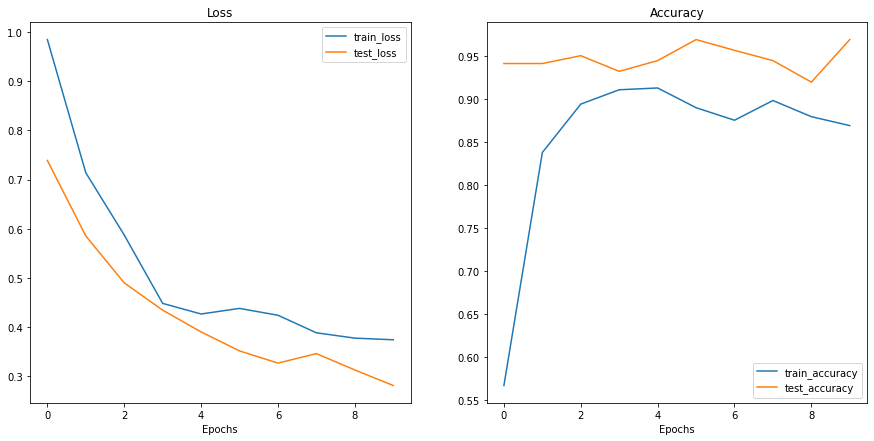

In [16]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor

In [17]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir='models',
                 model_name='09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth')

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Inpsecting the size of our EffNetB2 feature extractor

Why would it be important to consider the size of a saved model?

If we're deploying our model to be used on a mobile app/website there may be limited compute resources.

So if your model file is too large, we may not be able to fit it on the target device.

In [18]:
from pathlib import Path
model_path = Path('models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth')
effnetb2_size_in_mb = model_path.stat().st_size / (1024 ** 2)
print(f'effnetb2 model size: {round(effnetb2_size_in_mb, 2)}MB')

effnetb2 model size: 29.86MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [19]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())

effnetb2_total_params

7705221

In [20]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {
    'test_loss': effnetb2_results['test_loss'][-1],
    'test_acc': effnetb2_results['test_acc'][-1],
    'number_of_parameters': effnetb2_total_params,
    'model_size (MB)': effnetb2_size_in_mb
}

effnetb2_stats

{'test_loss': 0.28086441457271577,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.863232612609863}

## 4. Creating a ViT feature extractor

We're up to our second modelling experiment, repeating the steps for EffNetB2 but this time with a ViT feature extractor.

In [21]:
# Checkout the heads layer of the vit model
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [22]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
  # Create ViT_B_a6 pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze the base layers
  for param in model.parameters():
    param.requires_grad = False

  # Change the classifier head
  torch.manual_seed(seed)

  model.heads = nn.Sequential(
      nn.Linear(in_features=768, out_features=num_classes)
  )

  return model, transforms

In [23]:
vit, vit_transforms = create_vit_model()
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [24]:
from torchinfo import summary

# # Print ViT model summary (uncomment for full output) 
# summary(vit, 
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

### 4.1 Create DataLoaders for ViT feature Extractor

In [25]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [26]:
len(train_dataloader_vit), len(test_dataloader_vit), class_names, device

(15, 5, ['pizza', 'steak', 'sushi'], 'cuda')

### 4.1 Training ViT Feature Extractor

In [27]:
from going_modular.going_modular import engine

# Loss Function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
opt = torch.optim.Adam(params=vit.parameters(),
                       lr=1e-3)

# Train
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                            test_dataloader=test_dataloader_vit,
                            epochs=10,
                            optimizer=opt,
                            loss_fn=loss_fn,
                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7023 | train_acc: 0.7500 | test_loss: 0.2714 | test_acc: 0.9290
Epoch: 2 | train_loss: 0.2531 | train_acc: 0.9104 | test_loss: 0.1669 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1766 | train_acc: 0.9542 | test_loss: 0.1270 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1277 | train_acc: 0.9625 | test_loss: 0.1072 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1163 | train_acc: 0.9646 | test_loss: 0.0950 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1270 | train_acc: 0.9375 | test_loss: 0.0830 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0899 | train_acc: 0.9771 | test_loss: 0.0844 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0928 | train_acc: 0.9812 | test_loss: 0.0759 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0933 | train_acc: 0.9792 | test_loss: 0.0729 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0662 | train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9847


### 4.3 Plot loss curves of ViT Feature Extractor

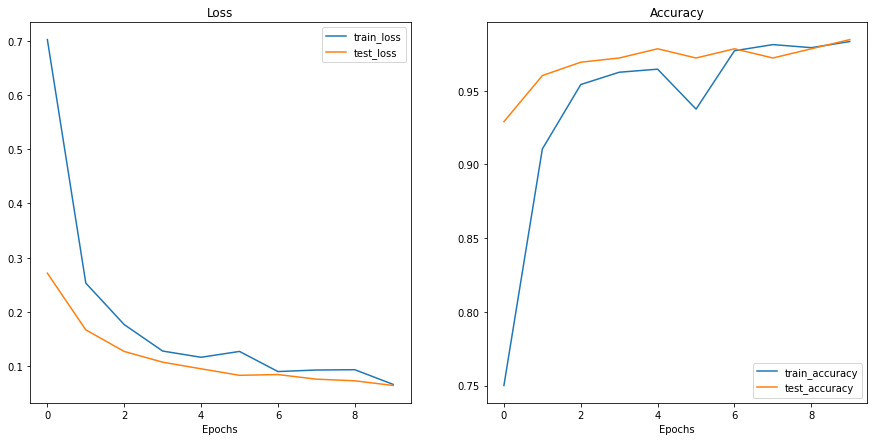

In [28]:
plot_loss_curves(vit_results)

### 4.4 Save ViT model and inspect the size

In [29]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=vit,
                 target_dir='models',
                 model_name='09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth')

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [30]:
from pathlib import Path
vit_model_path = Path('models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth')
vit_size_in_mb = vit_model_path.stat().st_size / (1024 ** 2)
print(f'ViT model size: {round(vit_size_in_mb, 2)}MB')

ViT model size: 327.37MB


### 4.6 Collecting ViT Feature Extractor Stats

In [31]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())

vit_total_params

85800963

In [32]:
vit_stats = {
    'test_loss': vit_results['test_loss'][-1], # -1 for the last epoch
    'test_acc': vit_results['test_acc'][-1],
    'number_of_parameters': vit_total_params,
    'model_size (MB)': vit_size_in_mb
}

vit_stats

{'test_loss': 0.06418211054988206,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37038707733154}

## 5. Making predictions with our trained models and timing

Our goal:
1. Performs well (95%+ test accuracy)
2. Fast (30+FPS)

To test criteria two:
1. Loop through test images
2. Time how long each model takes to make a prediction on the image

Let's work towards making a function called `pred_and_store()` to do so.

First we'll need a list of test image paths

In [33]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1994748.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/705150.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/46797.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/124279.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1944743.jpg')]

### 5.1 Creating a function to make predictions across test dataset

Steps to create `pred_and_store()`:
1. Create a function that takes a list of paths, a trained PyTorch model, a series of transforms, a list of target class names, and a target device.
2. Create an empty list (can return a full list of all predictions later).
3. Loop through the target input paths (the rest of the steps will be inside the loop)
4. Create an empty dictionary for each sample (prediction statistics will go in here)
5. Get the sample path and ground truth class from the filepath.
6. Start the prediction timer.
7. Open the image using `PIL.Image.open(path)`.
8. Transform the image to be usable with a given model.
9. Prepare the model for inference by sending it to the target device and turning on `eval()` mode.
10. Turnn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
11. Add the pred prob + pred class to empty dictionary from step 4.
12. End the prediction timer started in step 6 and add the time the prediction dictionary.
13. See if the predicted class matches the ground truth class.
14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
15. Return the list of prediction dictionaries.

In [34]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm

from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = 'cuda' if torch.cuda.is_available else 'cpu') -> List[Dict]:
  # 2. Create an empty list
  pred_list = []
  # 3. Loop through the target input paths
  for path in tqdm(paths):
    # 4. Create an empty dictionary for each sample
    pred_dict = {}

    # 5. Get the sample path and ground truth path from file path
    pred_dict['image_path'] = path
    class_name = path.parent.stem
    pred_dict['class_name'] = class_name

    # 6. Start the prediction timer
    start_time = timer()

    # 7. Open the image
    img = Image.open(path)

    # 8. Transform the image
    # 8.1 note that we add a batch dimension
    transformed_image = transform(img).unsqueeze(0).to(device)

    # 9. Put the model on the target device and into eval mode
    model = model.to(device)
    model.eval()

    # 10. Turnn on torch.inference_mode() and pass the target transformed
    # image to the model and perform forward pass + calculate pred prob + 
    # pred class.
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into pred prob
      pred_label = torch.argmax(pred_prob, dim=1) # prob into label index
      pred_class = class_names[pred_label.cpu()] # move pred to cpu (Python variables live on CPU)

      # 11. Add the pred to the output dict
      pred_dict['pred_prob'] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict['pred_class'] = pred_class

      # 12. End the timer and add the time to the dict
      end_time = timer()
      pred_dict['time_for_pred'] = round(end_time - start_time, 4)

    # 13. See if the predicted class matches the ground truth class
    pred_dict['correct'] = class_name == pred_class

    # 14. Append the dictionary to the list of predictions
    pred_list.append(pred_dict)

  # 15 . Return the lsit of prediction dictionaries
  return pred_list

### 5.2 Making and timing predictions with EffNetB2

Two things to note:

1. Device - we're going to hardcode predictions to happen on CPU (because you won't always be sure you'll have a GPU when you deploy your model).
2. Transforms - we want to make sure each of the models are predicting on images that have been prepared with the appropriate transforms (e.g. EffNetB2 with `effnetb2_transforms`)

In [35]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(
    paths=test_data_paths,
    model=effnetb2,
    transform=effnetb2_transforms,
    class_names=class_names,
    device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [36]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1994748.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.5362,
  'pred_class': 'sushi',
  'time_for_pred': 0.2639,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/705150.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.5944,
  'pred_class': 'sushi',
  'time_for_pred': 0.1158,
  'correct': True}]

In [37]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.5362,sushi,0.2639,True
1,data/pizza_steak_sushi_20_percent/test/sushi/7...,sushi,0.5944,sushi,0.1158,True
2,data/pizza_steak_sushi_20_percent/test/sushi/4...,sushi,0.9183,sushi,0.1019,True
3,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.5619,sushi,0.1136,True
4,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9188,sushi,0.1026,True


In [38]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

True     145
False      5
Name: correct, dtype: int64

In [39]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f'EffNetB average time per prediction: {effnetb2_average_time_per_pred}')

EffNetB average time per prediction: 0.1042


In [40]:
# Add average time per prediction to effnetb2 stats
effnetb2_stats['time_per_pred_cpu'] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28086441457271577,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.863232612609863,
 'time_per_pred_cpu': 0.1042}

> **Note:** Prediction times will vary (much like training times) depending on the hardware you're using. So generally the faster the compute the faster predictions will happen.

(Running the above on GPU will be 10x faster).

### 5.3 Making and timing predictions with ViT

In [41]:
# Make predictions across test dataset with ViT
vit_test_pred_dicts = pred_and_store(
    paths=test_data_paths,
    model=vit,
    transform=vit_transforms,
    class_names=class_names,
    device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [42]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9630,sushi,0.9428,True
1,data/pizza_steak_sushi_20_percent/test/sushi/7...,sushi,0.9447,sushi,0.9779,True
2,data/pizza_steak_sushi_20_percent/test/sushi/4...,sushi,0.9927,sushi,0.8209,True
3,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.8947,sushi,0.5495,True
4,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9959,sushi,0.5587,True


In [43]:
# Check number of correct predictions
vit_test_pred_df.correct.value_counts()

True     148
False      2
Name: correct, dtype: int64

In [44]:
# Find the average time per prediction for vit
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f'ViT average time per prediction: {vit_average_time_per_pred}')

ViT average time per prediction: 0.6189


In [45]:
# Add average time per prediction to ViT stats
vit_stats['time_per_pred_cpu'] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06418211054988206,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37038707733154,
 'time_per_pred_cpu': 0.6189}

## 6. Comparing model results, prediction times and size

In [46]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df['model'] = ['EffNetB2', 'ViT']

# Convert accuracy to percentages
df['test_acc'] = round(df['test_acc'] * 100, 2)
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.280864,96.88,7705221,29.863233,0.1042,EffNetB2
1,0.064182,98.47,85800963,327.370387,0.6189,ViT


Which model is better?

* `test_loss` (lower is better) - ViT
* `test_acc` (higher is better) - ViT
* `number_of_parameters` (generally lower is better*) - EffNetB2
  * *sometimes models with higher parameters can still run fast
* `model_size (MB)` - EffNetB2 (for our use case of mobile deployment smaller is better)
* `time_per_pred_cpu` - (lower is better, highly dependent on hardware) - EffNetB2

Both models fail to achieve our goal of 30+FPS, however we could always just try and use EffNetB2 and see how it goes.

In [47]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=df.set_index('model').loc['ViT'] / df.set_index('model').loc['EffNetB2'],
             columns=['ViT to EffNetB2 ratios']).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.228516,1.016412,11.135432,10.962323,5.939539


### 6.1 Visualizing the speed vs. performance tradeoff

So we've compared our EffNetB2 and ViT feature extractor models, now let's visualize the comparison with a speed vs. performance plot.

We can do so with matplotlib:
1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.
2. Add titles and labels to make our plot look nice.
3. Annotate the samples on the scatter plot so we know what's going on.
4. Create a legend based on the model sizes (`model_size (MB)`)

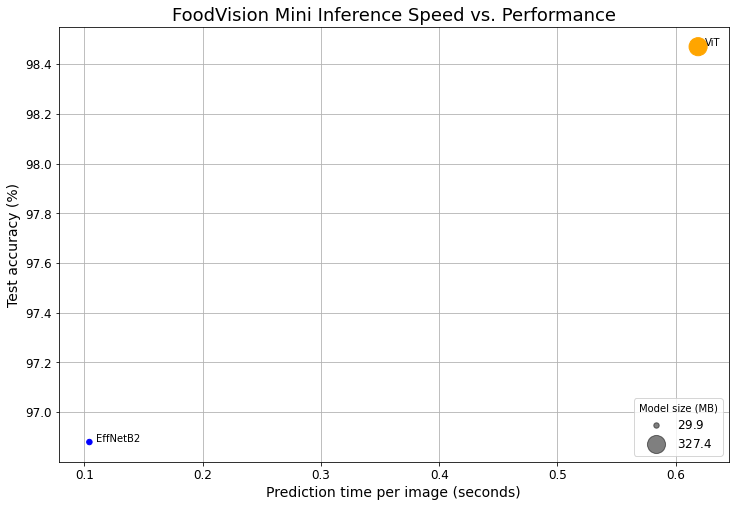

In [48]:
import matplotlib.pyplot as plt
# 1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x='time_per_pred_cpu',
                     y='test_acc',
                     c=['blue', 'orange'],
                     s='model_size (MB)')
# 2. Add titles and labels to make our plot look nice.
ax.set_title('FoodVision Mini Inference Speed vs. Performance', fontsize=18)
ax.set_xlabel('Prediction time per image (seconds)', fontsize=14)
ax.set_ylabel('Test accuracy (%)', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)
# 3. Annotate the samples on the scatter plot so we know what's going on.
for index, row in df.iterrows():
  ax.annotate(s=row['model'],
              xy=(row['time_per_pred_cpu']+0.006, row['test_acc']+0.003))
# 4. Create a legend based on the model sizes (`model_size (MB)`)
handles, labels = scatter.legend_elements(prop='sizes', alpha=0.5)
model_size_legend = ax.legend(handles, 
                              labels, 
                              loc='lower right', 
                              title='Model size (MB)',
                              fontsize=12)
# Save the figure
plt.savefig('09-foodvision-mini-inference-speed-vs-performance.png')

## 7. Bringing FoodVision Mini to life by creating a Gradio demo

We've chosen to deploy EffNetB2 as it fulfuls our criteria the best. (But look at onnx and OpenVINO for inference performance improvements).

What is Gradio? https://gradio.app/

> Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!



In [51]:
# Import/install Gradio
try:
  import gradio as gr
except:
  !pip -q install gradio
  import gradio as gr

print(f'Gradio version: {gr.__version__}')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### 7.1 Gradio overview

Gradio helps you create machine learning demos.

Why create a demo?

So other people can try our models and we can test them in the real world.

Deployment is as important as training.

The overall premise of Gradio is to map inputs -> function/model -> outputs.

### 7.2 Creating a function to map our inputs and outputs

In [52]:
# Put our model on the CPU
effnetb2 = effnetb2.to('cpu') # so we use the free tier on HuggingFace

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

Let's create a function called `predict()` to go from:

```
images of food -> ML model (EffNetB2) -> outputs food class
```

In [128]:
from typing import Tuple, Dict


def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  transformed_image = effnetb2_transforms(img).unsqueeze(0).to('cpu')

  # Put model into eval mode, make prediction
  effnetb2.eval()

  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(transformed_image), dim=1) # turn logits into pred prob

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = dict(zip(class_names, [i.item() for i in pred_probs[0]]))
  # pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  pred_time = round(timer() - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

In [129]:
test_image_path = test_data_paths[0]
test_image = Image.open(test_image_path)
probs, time = predict(test_image)
print(f'For {test_image_path}: {probs}, {time}')

For data/pizza_steak_sushi_20_percent/test/sushi/1994748.jpg: {'pizza': 0.0647243782877922, 'steak': 0.39906421303749084, 'sushi': 0.5362114310264587}, 0.1008


### 7.3 Creating a list of example images

The examples for Gradio can be created with the `examples` parameter.

In [135]:
import random
# Create a list of example inputs to our Gradio demo
example_list = [str(filepath) for filepath in random.sample(test_data_paths, k=3)]
example_list

['data/pizza_steak_sushi_20_percent/test/sushi/472912.jpg',
 'data/pizza_steak_sushi_20_percent/test/pizza/1618659.jpg',
 'data/pizza_steak_sushi_20_percent/test/pizza/1555015.jpg']

## 7.4 Building a Gradio Interface

Let's use `gr.Interface()` to go from:

```
input: image -> transform -> predict with EffNetB2 -> output: pred, prob, time
```

In [136]:
import gradio as gr

# Create title, description and article
title = "FoodVision Mini 🍕🥩🍣"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/efficientnetv2.html) computer vision model to classify images as pizza, steak or sushi."
article = "Created at 09. [PyTorch Model Deployment](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/09_pytorch_model_deployment.ipynb)."

demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type='pil'), 
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")], 
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# demo.launch(debug=False,
#             share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://dcdd974a-8f4f-4992.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


## 8. Turning our FoodVision Mini Gradio Demo into a deployable app

Gradio public demos expire in 72 hours, but we can put them up on Hugging Face Spaces.

### 8.1 What is Hugging Face Spaces?

Hugging Face spaces is an easy way to host an ML app. Or, you know, "github for machine learning"

### 8.2 Deployed Gradio app structure

We might have to use `git-lfs` for storing the model files.

We'll want all of our app files in a single directory.

```
Colab -> folder with all Gradio files -> upload app files to Hugging Face Spaces -> deploy
```

By the end our file structure will look like this:

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

You can see this in action:
* Deployed app - https://huggingface.co/spaces/mrdbourke/foodvision_mini
* Example file structure: https://huggingface.co/spaces/mrdbourke/foodvision_mini/tree/main
